In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize

In [2]:
def linear(p,x):
    return p[0]*x + p[1]

def residual(p,func, xvar, yvar, err):
    return (func(p, xvar) - yvar)/err

In [3]:
# The code below defines our data fitting function.
# Inputs are:
# initial guess for parameters p0
# the function we're fitting to
# the x,y, and dy variables
# tmi can be set to 1 or 2 if more intermediate data is needed

def data_fit(p0, func, xvar, yvar, err, tmi=0):
    try:
        fit = optimize.least_squares(residual, p0, args=(func,xvar, yvar, err), verbose=tmi)
    except Exception as error:
        print("Something has gone wrong:", error)
        return p0, np.zeros_like(p0), np.nan, np.nan
    pf = fit['x']

    print()

    try:
        cov = np.linalg.inv(fit['jac'].T.dot(fit['jac']))          
        # This computes a covariance matrix by finding the inverse of the Jacobian times its transpose
        # We need this to find the uncertainty in our fit parameters
    except:
        # If the fit failed, print the reason
        print('Fit did not converge')
        print('Result is likely a local minimum')
        print('Try changing initial values')
        print('Status code:', fit['status'])
        print(fit['message'])
        return pf, np.zeros_like(pf), np.nan, np.nan
            #You'll be able to plot with this, but it will not be a good fit.

    chisq = sum(residual(pf, func, xvar, yvar, err) **2)
    dof = len(xvar) - len(pf)
    red_chisq = chisq/dof
    pferr = np.sqrt(np.diagonal(cov)) # finds the uncertainty in fit parameters by squaring diagonal elements of the covariance matrix
    print('Converged with chi-squared {:.2f}'.format(chisq))
    print('Number of degrees of freedom, dof = {:.2f}'.format(dof))
    print('Reduced chi-squared {:.2f}'.format(red_chisq))
    print()
    Columns = ["Parameter #","Initial guess values:", "Best fit values:", "Uncertainties in the best fit values:"]
    print('{:<11}'.format(Columns[0]),'|','{:<24}'.format(Columns[1]),"|",'{:<24}'.format(Columns[2]),"|",'{:<24}'.format(Columns[3]))
    for num in range(len(pf)):
        print('{:<11}'.format(num),'|','{:<24.3e}'.format(p0[num]),'|','{:<24.3e}'.format(pf[num]),'|','{:<24.3e}'.format(pferr[num]))
    return pf, pferr, chisq,dof

# PMT Saturation

## Data

In [18]:
data1 = pd.read_csv('./data/scattering_1.csv').sort_values(by='theta')
data3 = pd.read_csv('./data/scattering_3.csv').sort_values(by='theta')

In [39]:
m1, b1, m_err1, b_err1 = 1.90199733, -19.4411994, 0.00113506, 0.42112607
m3, b3, m_err3, b_err3 = 1.50965791, -1.17649778, 0.00232081, 0.50328454

calibrate1 = lambda c, c_err: (m1 * c + b1, np.sqrt(c ** 2 * m_err1 ** 2 + m1 ** 2 * c_err ** 2 + b_err1 ** 2))
calibrate3 = lambda c, c_err: (m3 * c + b3, np.sqrt(c ** 2 * m_err3 ** 2 + m3 ** 2 * c_err ** 2 + b_err3 ** 2))

E_prime = lambda theta : 662 / (1 + (662/511) * (1 - np.cos(theta)))

In [40]:
thetas1 = data1['theta'] * (np.pi / 180)
channel1 = data1['centroid'] / (data1['gain'] * data1['fine_gain'])
channel_err1 = data1['centroid_err'] / (data1['gain'] * data1['fine_gain'])
energy1, energy_err1 = calibrate1(channel1, channel_err1)
data1['channel'] = channel1
data1['channel_err'] = channel_err1
data1['energy'] = energy1
data1['energy_err'] = energy_err1

thetas3 = data3['theta'] * (np.pi / 180)
channel3 = data3['centroid'] / (data3['gain'] * data3['fine_gain'])
channel_err3 = data3['centroid_err'] / (data3['gain'] * data3['fine_gain'])
energy3, energy_err3 = calibrate3(channel3, channel_err3)
data3['channel'] = channel3
data3['channel_err'] = channel_err3
data3['energy'] = energy3
data3['energy_err'] = energy_err3

## Plot

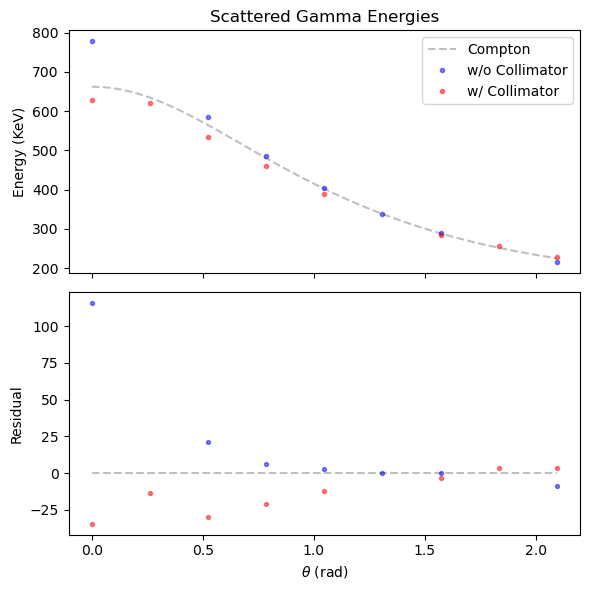

In [42]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

theta_space = np.linspace(thetas3.min(), thetas3.max())
ax0.errorbar(thetas1, energy1, fmt='b.', markersize=6, alpha=0.5, label='w/o Collimator')
ax0.errorbar(thetas3, energy3, fmt='r.', markersize=6, alpha=0.5, label='w/ Collimator')
ax0.plot(theta_space, E_prime(theta_space), color='k', linestyle='dashed', alpha=0.25, label='Compton')

#ax0.set_xlabel('$\\theta$ (rad)')
ax0.set_ylabel('Energy (KeV)')
ax0.set_title('Scattered Gamma Energies')
ax0.legend()

residuals1 = energy1 - E_prime(thetas1)
residuals3 = energy3 - E_prime(thetas3)
ax1.hlines(y=0, xmin=thetas3.min(), xmax=thetas3.max(), color='k', linestyle='dashed', alpha=0.25, label='Compton')
ax1.scatter(thetas1, residuals1, color='blue', s=8, alpha=0.5, label='w/o Collimator')
ax1.scatter(thetas3, residuals3, color='red', s=8, alpha=0.5, label='w/ Collimator')
ax1.set_xlabel('$\\theta$ (rad)')
ax1.set_ylabel('Residual')
plt.tight_layout()

In [10]:
#fig.savefig('./figures/pmt_saturation.pdf')